# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A3 - AUTOENCODERS**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 11/03/2024**
- **Fecha de Entrega: 17/03/2024**
- **Test: 18/03/2024**


In [1]:
import tensorflow as tf 
import warnings
warnings.filterwarnings('ignore')

# * Data manipulation 
import pandas as pd 
import numpy as np 
import os 

# * Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# * Scikit learn 
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE 

# * Keras 
from keras import layers 
from keras.layers import Input, Dense 
from keras.models import Model, Sequential 
from keras import regularizers

# Carga de datos

Vamos a usar los autoencoders para tratar de predecir si un pago con una tarjeta es un pago fraudulento. Para ello, usaremos un dataset de datos reales en el que por cuestiones de confidencialidad se han aplicado transformaciones a los campos. En concreto, se han tomado 29 características y se les ha aplicado un PCA. De esta forma, no es posible saber cuál es el significado de cada una de ellas.

La columna Class del dataset indica si es un pago fradulento (1) o si no lo es (0).

El dataset se puede descargar desde el siguiente enlace: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download


In [2]:
 # * from google.colab import drive
 # * drive.mount('/content/drive')

#### El dataset: 

El conjunto de datos en cuestión está diseñado para la detección de fraudes con tarjetas de crédito y contiene transacciones realizadas por tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos se centra particularmente en transacciones que ocurrieron durante dos días, con el objetivo de proporcionar una visión integral tanto de actividades fraudulentas como no fraudulentas.

**Estructura del Conjunto de Datos:**

El conjunto de datos consta de 284,807 filas y 31 columnas. Cada fila representa una transacción con tarjeta de crédito, y las columnas están estructuradas de la siguiente manera:
* **Tiempo:** Los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos.
* **V1 a V28:** Estos son los componentes principales obtenidos con PCA (Análisis de Componentes Principales). Las características originales no se proporcionan debido a problemas de confidencialidad. Estos componentes son el resultado de una técnica de reducción de dimensionalidad para proteger las identidades y características sensibles del usuario.
* **Monto:** El monto de la transacción; esta característica no está normalizada.
* **Clase:** La variable de respuesta, indicando fraude. Es una variable binaria donde "1" denota una transacción fraudulenta y "0" denota una transacción no fraudulenta.

**Puntos Clave**
* El conjunto de datos es altamente desequilibrado, con 492 fraudes entre 284,807 transacciones, lo que representa una fracción muy pequeña del total de transacciones.
* Las características V1 a V28 son las únicas variables numéricas de entrada. Estas características son el resultado de una transformación PCA, que es una técnica común utilizada para anonimizar datos sensibles.
* Las características Tiempo y Monto no están transformadas por PCA, lo que significa que son las únicas características directamente relacionadas con las propiedades originales de la transacción.
* La columna Clase es crucial para los modelos de aprendizaje supervisado, ya que etiqueta cada transacción como fraudulenta o no, permitiendo el entrenamiento de modelos para detectar patrones asociados con el fraude.


In [3]:
pd_data = pd.read_csv('creditcard.csv')
pd_data
# * Google Collab Data
# * pd_data = pd.read_csv("/content/drive/MyDrive/data/creditcard.csv").drop(columns=["Time"])
# * pd_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Exploratorio
Realice un exploratorio simple de las features. Céntrese en la columna "Amount" que no ha sido tranformada y el target de la columna "Class".

Datos numéricos a primera vista

In [4]:
pd_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Información general de los datos: 

In [5]:
pd_data.info()
pd_data.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

False

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


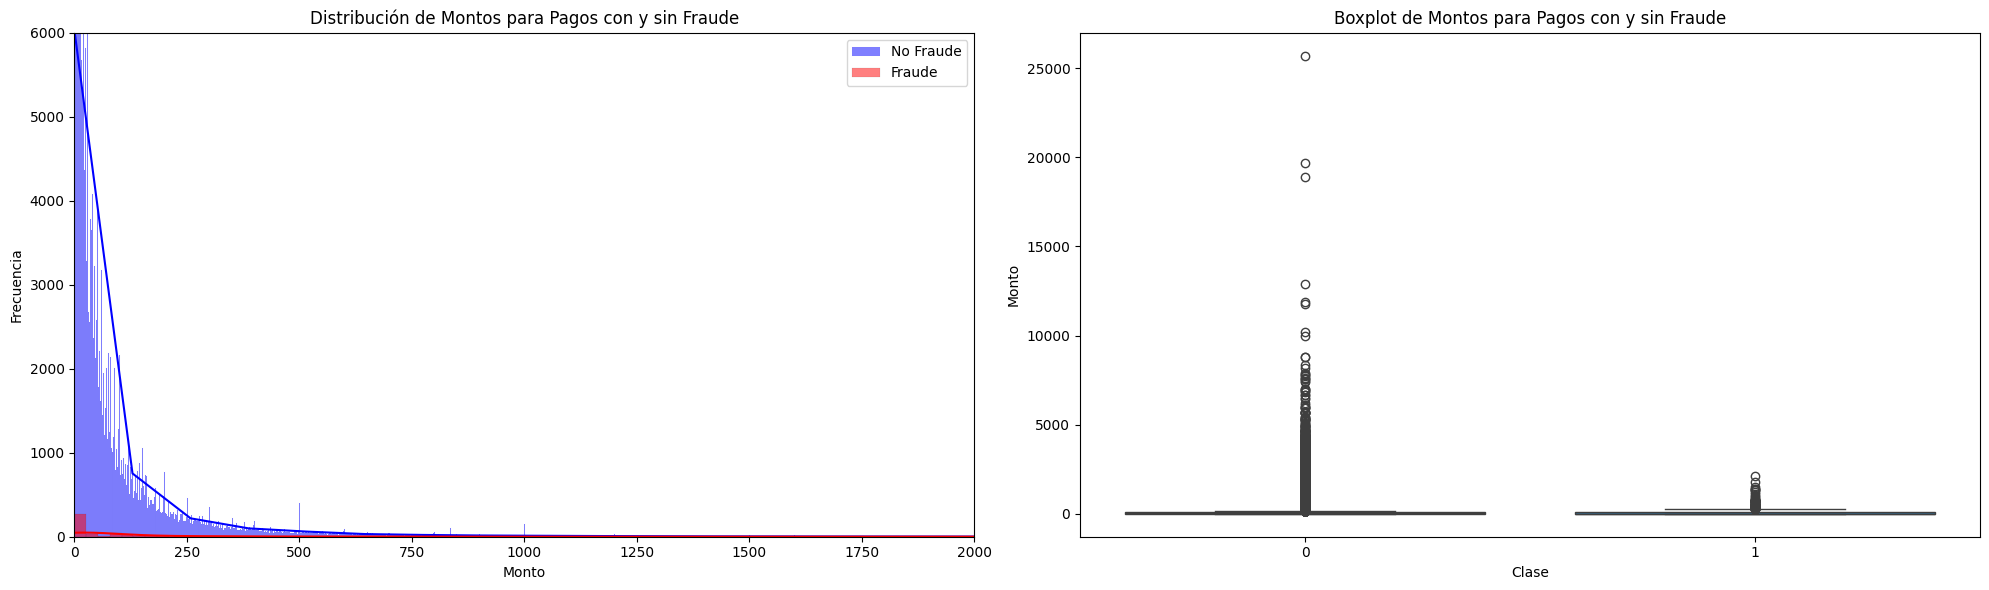

In [6]:
 # * Estadísticas descriptivas para la columna "Amount"
print(pd_data['Amount'].describe())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# * Histograma para la distribución de "Amount" por clase
sns.histplot(pd_data[pd_data['Class'] == 0]['Amount'], ax=axes[0], color='blue', kde=True, label='No Fraude')
sns.histplot(pd_data[pd_data['Class'] == 1]['Amount'], ax=axes[0], color='red', kde=True, label='Fraude')
max_frequency = 6000
axes[0].set_ylim(0, max_frequency)
axes[0].set_xlim(0, 2000)
axes[0].set_title('Distribución de Montos para Pagos con y sin Fraude')
axes[0].set_xlabel('Monto')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# * Boxplot para la distribución de "Amount" por clase
sns.boxplot(x='Class', y='Amount', data=pd_data, ax=axes[1])
axes[1].set_title('Boxplot de Montos para Pagos con y sin Fraude')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Monto')

# Mostrar la figura con ambos subplots
plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()

Proporción de pagos reales vs. fraudulentos: (Escala logaritmica)

* Como se puede observar, hay un gran desequilibrio entre ambas clases

Text(0, 0.5, 'Frequency')

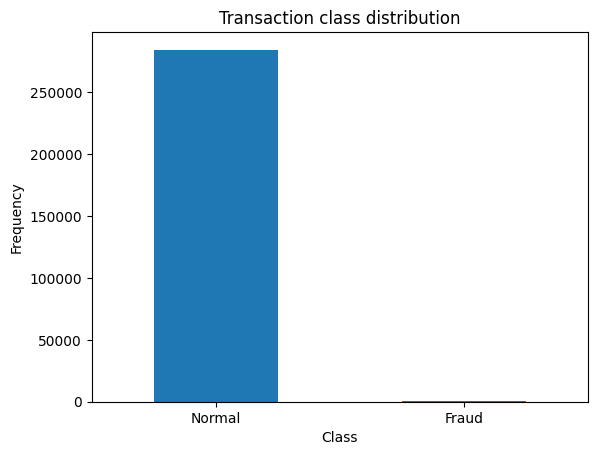

In [7]:
count_classes = pd.value_counts(pd_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")


# Preprocesado

Aplique una normalización para que las features estén en el intervalo 0 a 1. Además, divida el dataset en train y test.

* Como hemos observado en el EDA, tenemos un desequilibrio muy grande entre las dos clases de pagos, por lo tanto vamos a jugar con muestras, para equilibrarlo y evitar overfitting. 
* Igualmente, el tiempo lo tenemos en segundos el cual no nos va a ser muy útiles, y lo debemos de pasar a días

In [8]:
 # * Copiamos el dataset original para manipularlo 
pd_data_pr = pd_data.copy()
pd_data_pr = pd_data_pr.drop(['Time'], axis = 1)

genuine_trx = pd_data_pr[pd_data_pr['Class'] == 0]
fraud_trx = pd_data_pr[pd_data_pr['Class'] == 1] 

In [9]:

print(f'Clean & Balanced version of the data with time in days: {pd_data_pr.shape}')

Clean & Balanced version of the data with time in days: (284807, 30)


In [10]:
X = pd_data_pr.drop('Class', axis = 1)
y = pd_data_pr['Class']
print(f"Features: {X.shape} and Target: {y.shape}")

Features: (284807, 29) and Target: (284807,)


#### Visualización de datos con t-SNE
TSNE (t-distributed Stochastic Neighbor Embedding) es una tecnica en apredizaje no supervisado para la reducción de dimensionalidad distinta a PCA y SVD.

In [11]:
def dimensionality_plot(X,y, title):
    sns.set_theme(style='whitegrid', palette =  'muted')
    #Intializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state = 42)
    
    # Fitting the data
    X_trans = tsne.fit_transform(X)
    
    plt.figure(figsize = (12,8))
    
    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y==0), 1], marker='o', color='g', linewidths=1, alpha=0.8, label='Genuine')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y==1), 1], marker='o', color='red', linewidths=1, alpha=0.8, label='Fraud')
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()    

Ahora que tenemos el dataset limpio, vamos a aplicar el escalado relevante:

In [20]:
 # ! - Definimos el scaler
scaler = StandardScaler()

scaler_fit = scaler.fit_transform(X)
pd_data_pr.iloc[:, :-1] = scaler_fit # * Mismo que la previa definición

#X_scaled = pd_data_pr.iloc[:, :-1] # * Reconversión for format
#X_scaled_genuine = scaler_fit[y == 0]
#X_scaled_fraud = scaler_fit[y == 1]

Podemos observar aquí que no hay una clara distincción de patrones entre los 'genuine' y los 'fraud'. Y es por ello que los auto-encoders nos ayudarán a encontrar los patrones

# Auto encoder

Se requiere construir un mecanismo para la detección de anomalías con un autoencoder. Vamos a considerar que los pagos fraudulentos son poco comunes y tienen algunas características especiales que no tienen el resto de pagos.

## Creación del modelo

Cree un autoencoder con encoder y decoder simétricos. Dos capas en cada uno serán suficientes, y tome como dimensión del Latent un valor entre 4 y 10.

Atención a la función de activación de la última capa del decoder!!!

----

Como metodo, vamos a entrenar el autoencoder, con el fin de que los fraudes sean outliers. Por lo cual nos interesa entrenarlo solo con los pagos verdaderos. 

In [25]:
    # * Dividimos el dataset en train y test
X_train, X_test = train_test_split(pd_data_pr, test_size= 0.2, random_state=42)

X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class'], axis = 1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values

## Normal Auto-Encoder

In [29]:
 # * Definimos la dimensión de nuestras entradas y del espacio latente
input_dim = X_train.shape[1]  # * Número de características
latent_dim = 8  # * Dimensión del espacio latente

# * Definimos el encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='tanh')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)

# * Definimos el decoder
decoded = Dense(16, activation='tanh')(encoded)

# * Capa de salida: 
output_layer = Dense(input_dim, activation='sigmoid')(decoded) # usamos 'sigmoid' para asegurar que la salida esté en el rango [0, 1]

# * Creamos el modelo de autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Entrenamiento

Entrene el modelo hasta alcanzar la convergencia necesaria para la detección de anomalías.

In [30]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test)).history

Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step - accuracy: 0.1286 - loss: -1.2685 - val_accuracy: 0.1520 - val_loss: -5.5779
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step - accuracy: 0.1519 - loss: -6.9713 - val_accuracy: 0.1516 - val_loss: -11.3066
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step - accuracy: 0.1533 - loss: -12.7114 - val_accuracy: 0.1542 - val_loss: -17.1409
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 450us/step - accuracy: 0.1575 - loss: -18.5535 - val_accuracy: 0.1604 - val_loss: -23.0389
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step - accuracy: 0.1646 - loss: -24.3972 - val_accuracy: 0.1645 - val_loss: -29.0017
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 449us/step - accuracy: 0.1662 - loss: -30.3993 - val_accuracy: 0.1669 - val_loss: -34.9782
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step - accuracy: 0.1694 - loss: -36.3862 - val_accuracy: 0.1647 - val_loss: -40.9647
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3

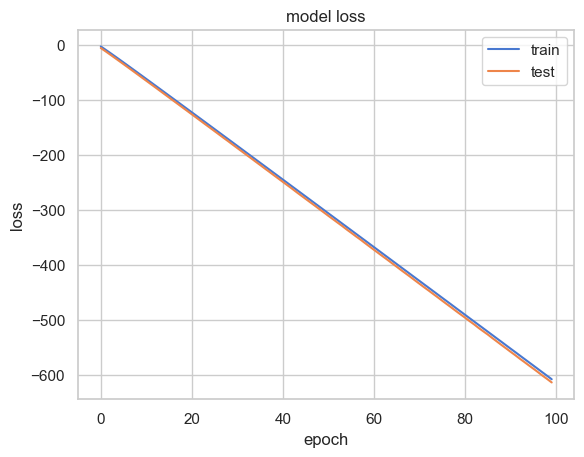

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

##### Usamos el Auto-encoder para codificar los datos

In [95]:
latent_model = Sequential()
# * Codificamos los datos de entrada, con las 3 primeras capas del auto-encoder
for i in range(2):
    latent_model.add(autoencoder.layers[i])    

In [96]:
genuine_encoded_points = latent_model.predict(X_scaled_genuine)
fraud_encoded_points = latent_model.predict(X_scaled_fraud)
# * One collection 
y_genuine = np.zeros(genuine_encoded_points.shape[0])
y_fraud = np.ones(fraud_encoded_points.shape[0])

encoded_X = np.append(genuine_encoded_points, fraud_encoded_points, axis = 0)
encoded_y = np.append(y_genuine, y_fraud, axis = 0)

  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


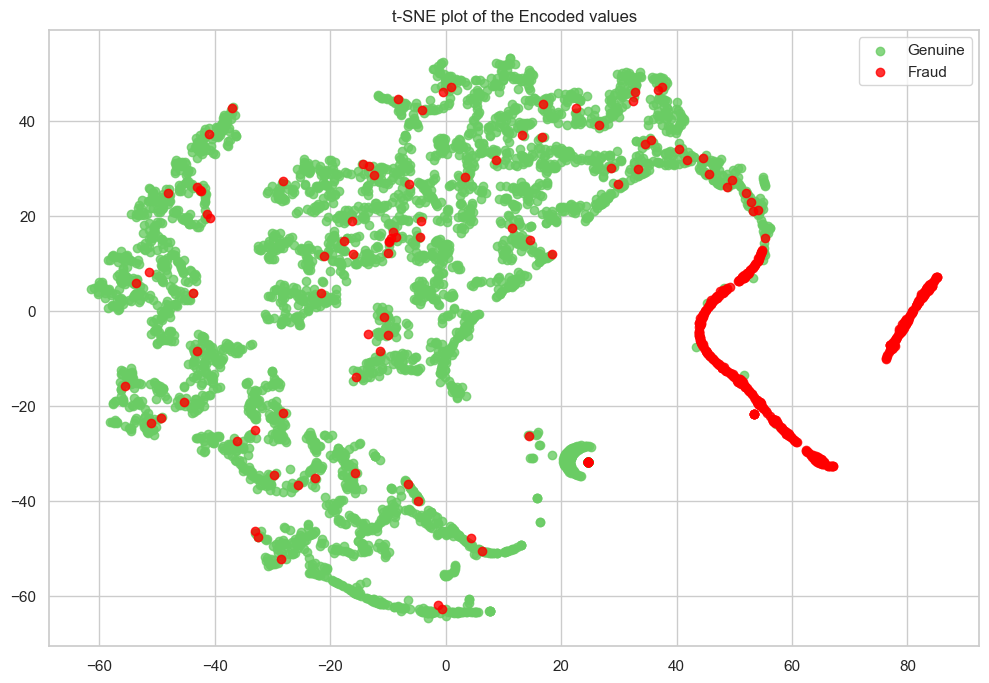

In [97]:
 # * Visualizamos los datos nuevos codificados con el TSNE
dimensionality_plot(encoded_X, encoded_y, 't-SNE plot of the Encoded values')

Se visualiza una tendencia menos esparcida que la previa, pero no una mejora enorme

In [35]:
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(encoded_X, encoded_y, test_size=0.2)

In [36]:
print(f"Encoded train fata X: {X_enc_train.shape}, Y: {y_enc_train.shape}, X_test: {X_enc_test.shape}, Y_test: {y_enc_test.shape}")
print(f"Actual train & test data X: {X_train.shape}, Y: {X_train.shape}, X:text : {X_test.shape}, Y_test: {y_test.shape}")

Encoded train fata X: (3593, 16), Y: (3593,), X_test: (899, 16), Y_test: (899,)
Actual train & test data X: (3593, 30), Y: (3593, 30), X:text : (899, 30), Y_test: (899,)


Ahora podemos observar que los pagos fraudulentos se han desplazado hacia un grupo, con un procentaje más bajo oculto entre las transacciones normales. 

----

  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


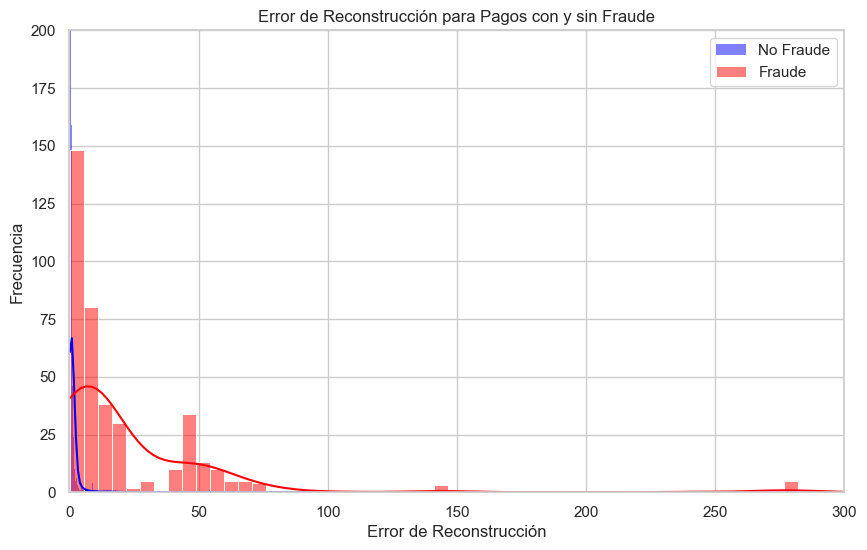

In [50]:
# Calculamos las reconstrucciones del conjunto de entrenamiento
X_train_pred = autoencoder.predict(X_train)

# Calculamos el error cuadrático medio para cada muestra
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# Creamos un DataFrame para facilitar el análisis
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_train})

# Dibujamos el histograma del error en los pagos fraudulentos y en los normales por separado
plt.figure(figsize=(10, 6))
sns.histplot(error_df[error_df['True_class'] == 0]['Reconstruction_error'], color='blue', kde=True, label='No Fraude')
sns.histplot(error_df[error_df['True_class'] == 1]['Reconstruction_error'], color='red', kde=True, label='Fraude')
plt.ylim(0,200)
plt.xlim(0,300)
plt.title('Error de Reconstrucción para Pagos con y sin Fraude')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

## Elección del threshold
Vamos a tratar de elegir un buen valor de threshold del error para decidir si es un pago fradulento o no lo es. Para ello, tome unos 100 valores en el rango que toma el threshold y calcule sobre el dataset de train la precisión, el recall, el false positive rate y el true positive rate. Pinte cada uno de ellos en una gráfica (el eje x es el posible valor del threshold).

In [38]:
def false_positive_rate(y, y_pred):
    """y is 0, y_pred is 1"""
    return sum( (1- y) * y_pred) / sum(1-y)
def true_positive_rate(y, y_pred):
    """both are one"""
    return sum(y * y_pred) / sum(y)

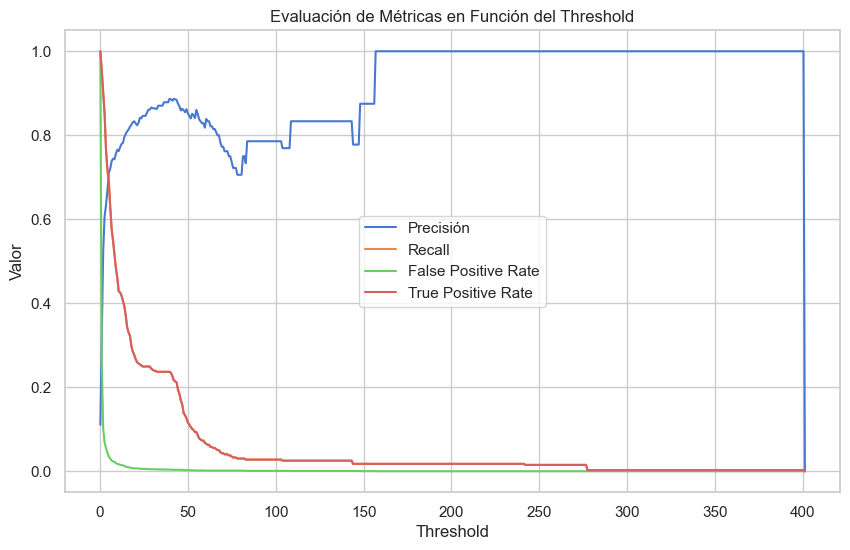

In [39]:
threshold_values = np.linspace(min(mse), max(mse), 500)
precision_values = []
recall_values = []
fpr_values = []
tpr_values = []

for threshold in threshold_values:
    # Etiquetamos las predicciones basadas en el threshold
    predictions = (error_df['Reconstruction_error'] > threshold).astype(int)

    # Calculamos métricas
    precision = precision_score(error_df['True_class'], predictions)
    recall = recall_score(error_df['True_class'], predictions)

    tn, fp, fn, tp = confusion_matrix(error_df['True_class'], predictions).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    # Almacenamos los valores de las métricas
    precision_values.append(precision)
    recall_values.append(recall)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

# Dibujamos las métricas en función del threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_values, label='Precisión')
plt.plot(threshold_values, recall_values, label='Recall')
plt.plot(threshold_values, fpr_values, label='False Positive Rate')
plt.plot(threshold_values, tpr_values, label='True Positive Rate')
plt.title('Evaluación de Métricas en Función del Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend()
plt.show()

No hay 3 lineas, es solo que Recall y True Positive Rate estan fuertemente asociados. 

## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

In [59]:
# Tomar un valor de threshold adecuado (puedes elegirlo manualmente o de la gráfica anterior)
chosen_threshold = 40

# Etiquetar las predicciones en el conjunto de prueba basado en el threshold elegido
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
predictions_test = (mse_test > chosen_threshold).astype(int)

# Calcular métricas en el conjunto de prueba
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predictions_test).ravel()
fpr_test = fp_test / (fp_test + tn_test)
tpr_test = tp_test / (tp_test + fn_test)

# Mostrar las métricas en el conjunto de prueba
print(f'Precisión en el conjunto de prueba: {precision_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')
print(f'False Positive Rate en el conjunto de prueba: {fpr_test:.4f}')
print(f'True Positive Rate en el conjunto de prueba: {tpr_test:.4f}')


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
Precisión en el conjunto de prueba: 0.8333
Recall en el conjunto de prueba: 0.2105
False Positive Rate en el conjunto de prueba: 0.0050
True Positive Rate en el conjunto de prueba: 0.2105


# Sparse AutoEncoder

## Creación del modelo
Repitamos todo el proceso pero usando un sparse autoencoder. Solamente añada regularización l1 en la última capa del encoder. Además, puede probar a aumentar un poco la dimensión del encoding.

In [41]:
 # * Definimos la dimensión de nuestras entradas y del espacio latente
input_dim = X_train.shape[1]  # * Número de características
latent_dim = 8  # * Dimensión del espacio latente

# * Definimos el encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)

# * Definimos el decoder
decoded = Dense(16, activation='tanh')(encoded)

# * Capa de salida: 
output_layer = Dense(input_dim, activation='sigmoid')(decoded) # usamos 'sigmoid' para asegurar que la salida esté en el rango [0, 1]

# * Creamos el modelo de autoencoder
sparse_autoencoder = Model(input_layer, output_layer)
sparse_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Entrenamiento

In [98]:
history = sparse_autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test)).history

Epoch 1/100
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -2.4323

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.3836 - val_loss: -3.0739
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -2.8162 - val_loss: -3.1938
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -2.7425 - val_loss: -3.3062
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -2.5794 - val_loss: -3.4186
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -2.8069 - val_loss: -3.5439
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -2.9432 - val_loss: -3.6595
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.1112 - val_loss: -3.7777
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.0359 - val_loss: -3.8901
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.3048 - val_loss: -4.0087
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.2151 - val_loss: -4.1243
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.3610 - val_loss: -4.2423
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

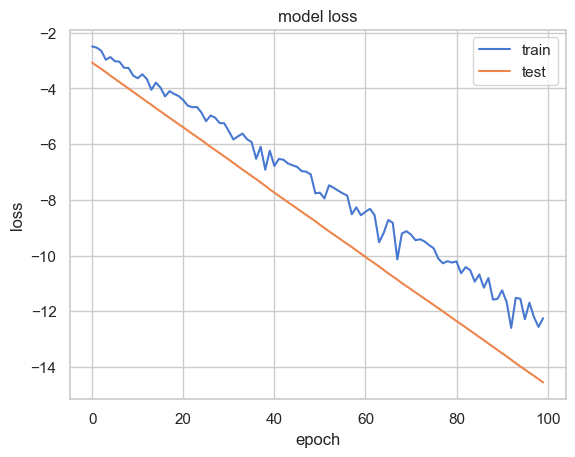

In [99]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

**Reintentamos usar el auto-encoder para codificar los valores**

In [43]:
sparse_latent_model = Sequential()
# * Codificamos los datos de entrada, con las 3 primeras capas del auto-encoder
for i in range(2):
    sparse_latent_model.add(sparse_autoencoder.layers[i])    

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


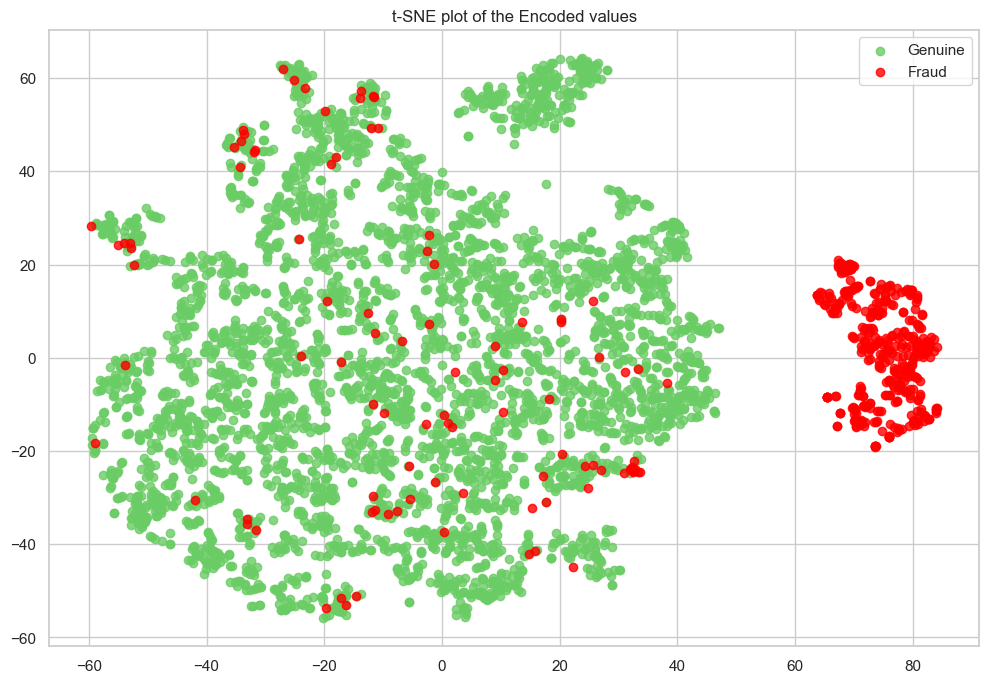

In [44]:
genuine_encoded_points = sparse_latent_model.predict(X_scaled_genuine)
fraud_encoded_points = sparse_latent_model.predict(X_scaled_fraud)
y_genuine = np.zeros(genuine_encoded_points.shape[0])
y_fraud = np.ones(fraud_encoded_points.shape[0])

encoded_X = np.append(genuine_encoded_points, fraud_encoded_points, axis = 0)
encoded_y = np.append(y_genuine, y_fraud, axis = 0)

 # * Visualizamos los datos nuevos codificados con el TSNE
dimensionality_plot(encoded_X, encoded_y, 't-SNE plot of the Encoded values')

Podemos observar que ahora los patrones para los pagos fraudulentos estan mucho mejor clasificados que en el autoencoder normal. Esto se debe a que el sparse es más sensible a discrepancias en los datos

## Análisis de error de reconstrucción
Calcule el error cuadrático medio entre cada una de las muestras del dataset de train y la reconstrucción pasando por el autoencoder. Dibuje el histograma del error en los pagos fraudulentos y en los normales por separado en una misma gráfica. Comente los resultados.

  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


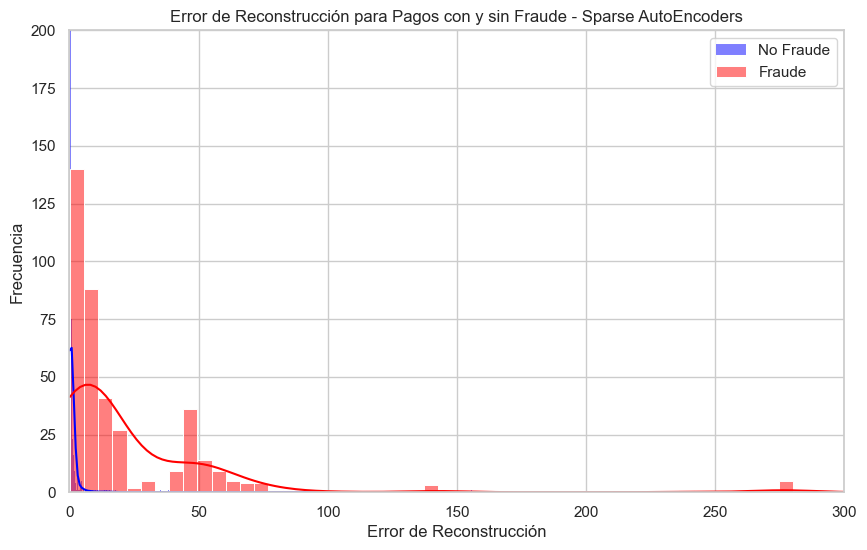

In [53]:
# Calculamos las reconstrucciones del conjunto de entrenamiento
X_train_pred = sparse_autoencoder.predict(X_train)

# Calculamos el error cuadrático medio para cada muestra
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# Creamos un DataFrame para facilitar el análisis
sparse_error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_train})

# Dibujamos el histograma del error en los pagos fraudulentos y en los normales por separado
plt.figure(figsize=(10, 6))
sns.histplot(sparse_error_df[sparse_error_df['True_class'] == 0]['Reconstruction_error'], color='blue', kde=True, label='No Fraude') # type: ignore
sns.histplot(sparse_error_df[sparse_error_df['True_class'] == 1]['Reconstruction_error'], color='red', kde=True, label='Fraude') # type: ignore
plt.ylim(0,200)
plt.xlim(0,300)
plt.title('Error de Reconstrucción para Pagos con y sin Fraude - Sparse AutoEncoders')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

## Elección del threshold
Calcule las mismas métricas de antes en función del threshold. Pinte en la misma gráfica la curva del autoencoder y la del sparse autoencoder. ¿Cuál funciona mejor?

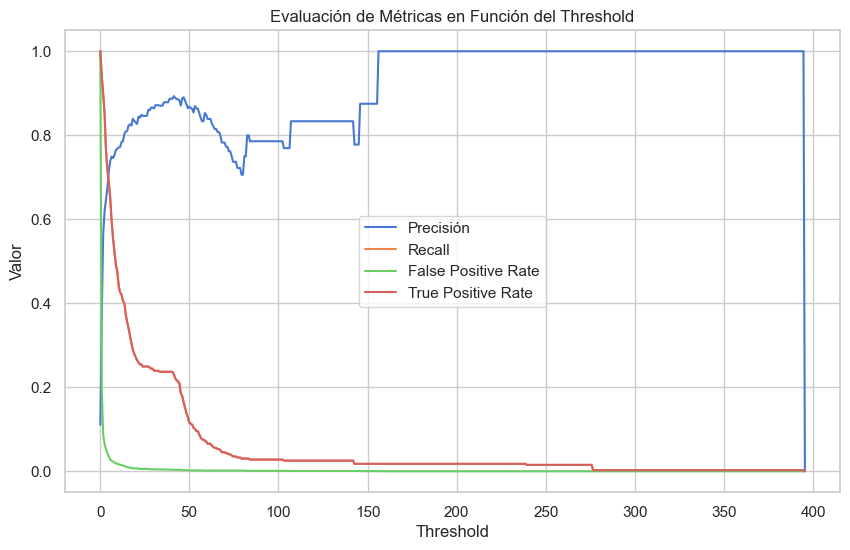

In [54]:
threshold_values = np.linspace(min(mse), max(mse), 500)
precision_values = []
recall_values = []
fpr_values = []
tpr_values = []

for threshold in threshold_values:
    # Etiquetamos las predicciones basadas en el threshold
    predictions = (sparse_error_df['Reconstruction_error'] > threshold).astype(int)

    # Calculamos métricas
    precision = precision_score(sparse_error_df['True_class'], predictions)
    recall = recall_score(sparse_error_df['True_class'], predictions)

    tn, fp, fn, tp = confusion_matrix(sparse_error_df['True_class'], predictions).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    # Almacenamos los valores de las métricas
    precision_values.append(precision)
    recall_values.append(recall)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

# Dibujamos las métricas en función del threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_values, label='Precisión')
plt.plot(threshold_values, recall_values, label='Recall')
plt.plot(threshold_values, fpr_values, label='False Positive Rate')
plt.plot(threshold_values, tpr_values, label='True Positive Rate')
plt.title('Evaluación de Métricas en Función del Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend()
plt.show()

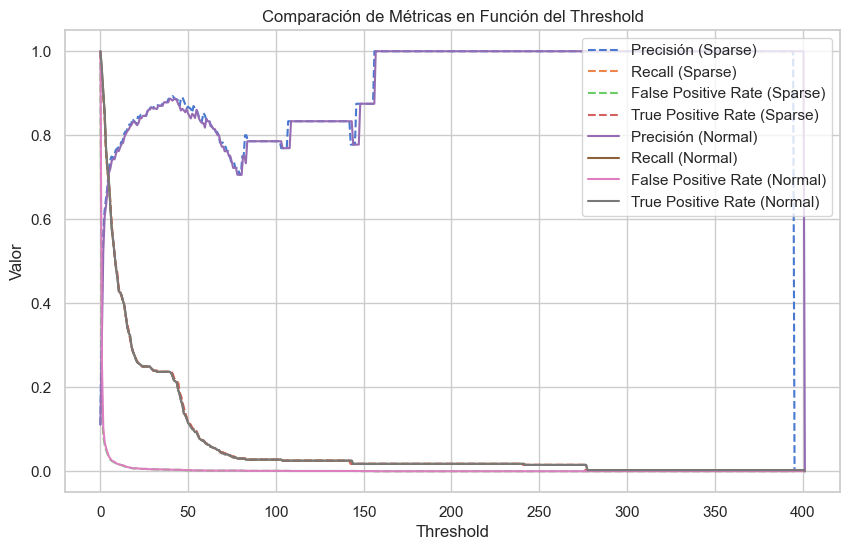

In [64]:
def calculate_and_plot_metrics(error_df, label_prefix, linestyle='-'):
    threshold_values = np.linspace(min(error_df['Reconstruction_error']), max(error_df['Reconstruction_error']), 500)
    precision_values = []
    recall_values = []
    fpr_values = []
    tpr_values = []

    for threshold in threshold_values:
        predictions = (error_df['Reconstruction_error'] > threshold).astype(int)
        precision = precision_score(error_df['True_class'], predictions)
        recall = recall_score(error_df['True_class'], predictions)
        tn, fp, fn, tp = confusion_matrix(error_df['True_class'], predictions).ravel()
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        
        precision_values.append(precision)
        recall_values.append(recall)
        fpr_values.append(fpr)
        tpr_values.append(tpr)

    # Plotting
    plt.plot(threshold_values, precision_values, label=f'Precisión ({label_prefix})', linestyle=linestyle)
    plt.plot(threshold_values, recall_values, label=f'Recall ({label_prefix})', linestyle=linestyle)
    plt.plot(threshold_values, fpr_values, label=f'False Positive Rate ({label_prefix})', linestyle=linestyle)
    plt.plot(threshold_values, tpr_values, label=f'True Positive Rate ({label_prefix})', linestyle=linestyle)


plt.figure(figsize=(10, 6))
calculate_and_plot_metrics(sparse_error_df, 'Sparse', linestyle='--') # * Sparse Autoencoder
calculate_and_plot_metrics(error_df, 'Normal')                        # * Normal Autoencoder

plt.title('Comparación de Métricas en Función del Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend(loc='upper right')
plt.show()

## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

Observamos que dan mejores resultados con minima discrepancia el Sparse Autoencoder. Hay gran precisión, pero observamos que hay un True Positive rate bastante bajo, al igual que con el recall

In [79]:
# Tomar un valor de threshold adecuado (puedes elegirlo manualmente o de la gráfica anterior)
chosen_threshold = 40

# Etiquetar las predicciones en el conjunto de prueba basado en el threshold elegido
X_test_pred = sparse_autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
predictions_test = (mse_test > chosen_threshold).astype(int)

# Calcular métricas en el conjunto de prueba
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predictions_test).ravel()
fpr_test = fp_test / (fp_test + tn_test)
tpr_test = tp_test / (tp_test + fn_test)

# Mostrar las métricas en el conjunto de prueba
print(f'Precisión en el conjunto de prueba: {precision_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')
print(f'False Positive Rate en el conjunto de prueba: {fpr_test:.4f}')
print(f'True Positive Rate en el conjunto de prueba: {tpr_test:.4f}')


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
Precisión en el conjunto de prueba: 0.8333
Recall en el conjunto de prueba: 0.2105
False Positive Rate en el conjunto de prueba: 0.0050
True Positive Rate en el conjunto de prueba: 0.2105


# Elección del threshold en base a un Caso de Uso
En este apartado tome la versión del autoencoder que haya dado mejores resultados.

Planteemos el siguiente Caso de Uso:

Cuando detectamos que un pago puede ser fraudulento, podemos hacer una llamada al cliente para que confirme que ha sido él quien ha realizado el pago; en este caso estimamos el coste de la llamada en 50 céntimos.
También podemos confiar en que el cliente posteriormente nos llame para notificar el fraude y cancelar el pago; en este caso, se realiza una gestión más cara que estimamos en unos 2 euros.

¿Cuál debería ser el threshold para minimizar el coste? Explique el razonamiento.

**Respuesta:**
Para poder minimizar el coste, debemos de generar una función de optimización para equilibrar los costes de intervención y de pasividad, teniendo en cuenta la precisión y el recall del modelo de detección (por el auto-encoder). 
* El coste de llamar innecesariamente a los clientes se asocia con los falsos positivos. False Positive Rate $\times$ Cost Call
* El coste de gestionar la reclamación, sería asociado con los falsos negativos. False Negative Rate $\times$ Cancellation Cost 

Es decir: 

$C_{total} = (C_{FP} \times FPR) + (C_{FN} \times FNR)$

Lo que tenemos que hacer ahora es variar el umbral y minimizar el resultado. 

In [81]:
COST_CALL = 0.5
COST_CANCELLATION = 2

In [82]:
def calculate_costs(threshold, fp, fn, cost_call=COST_CALL, cost_cancellation=COST_CANCELLATION):
    cost = (fp*cost_call) + (fn*cost_cancellation)
    return cost 

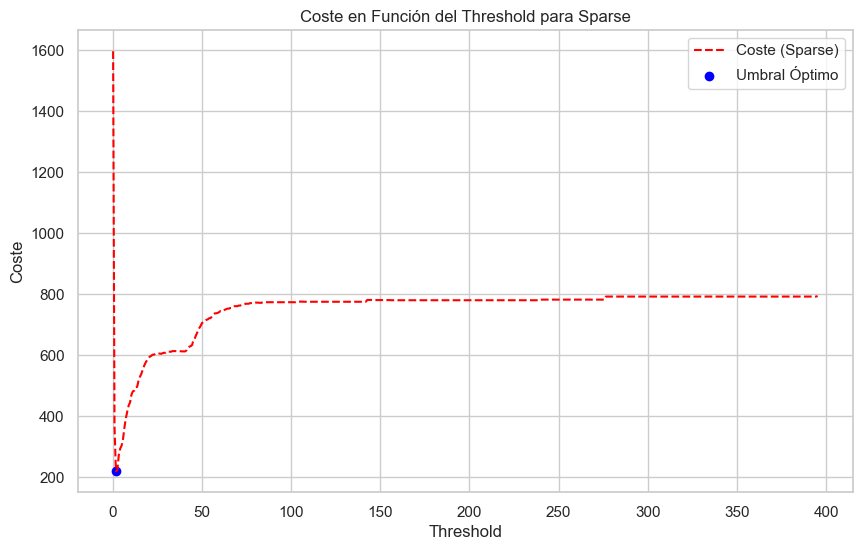

Umbral óptimo (Sparse): 1.6928245243725697, Coste mínimo: 218.5


In [85]:

from sklearn.metrics import precision_score, recall_score, confusion_matrix

def calculate_plot_metrics_with_cost(error_df, label_prefix, linestyle='-'):
    threshold_values = np.linspace(min(error_df['Reconstruction_error']), max(error_df['Reconstruction_error']), 500)
    cost_values = []  # Para almacenar el coste para cada umbral

    for threshold in threshold_values:
        predictions = (error_df['Reconstruction_error'] > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(error_df['True_class'], predictions).ravel()
        
        # Calcular coste para el umbral actual
        current_cost = calculate_costs(threshold, fp, fn)
        cost_values.append(current_cost)

    # Encontrar el umbral con el mínimo coste
    min_cost_index = np.argmin(cost_values)
    optimal_threshold = threshold_values[min_cost_index]
    min_cost = cost_values[min_cost_index]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, cost_values, label=f'Coste ({label_prefix})', linestyle=linestyle, color='red')
    plt.scatter(optimal_threshold, min_cost, color='blue', label='Umbral Óptimo')
    
    plt.title(f'Coste en Función del Threshold para {label_prefix}')
    plt.xlabel('Threshold')
    plt.ylabel('Coste')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    return optimal_threshold, min_cost

optimal_threshold_sparse, min_cost_sparse = calculate_plot_metrics_with_cost(sparse_error_df, 'Sparse', linestyle='--')
print(f"Umbral óptimo (Sparse): {optimal_threshold_sparse}, Coste mínimo: {min_cost_sparse}")

# Conclusiones del estudio

Detallar las principales conclusiones extraidas sobre la construcción del modelo Autoencoder, la comparativa entre modelos y su aplicación en sistemas de detección de anomalías.

*Escribir AQUI las conclusiones*